# Generation of protein file for pan-genome sample files

### Import Modules

In [1]:
import os
from collections import Counter
import seaborn as sns
from supervenn import supervenn
from glob import glob
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import Bio
from Bio import BiopythonWarning
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', BiopythonWarning)
    from Bio import SeqIO

In [2]:
os.chdir('/mnt/nfs/wangd/project/paper_db/')

### Define directories and parameters

In [3]:
cdna_dir = 'cdna_files'
try:
    os.mkdir(cdna_dir)
except FileExistsError:
    pass

prot_dir = 'prot_files'
try:
    os.mkdir(prot_dir)
except FileExistsError:
    pass

pep_dir = 'pep_files'
try:
    os.mkdir(pep_dir)
except FileExistsError:
    pass

tryptic_pep_dir = 'tryptic_pep_files'
try:
    os.mkdir(tryptic_pep_dir)
except FileExistsError:
    pass

min_pep_len = 7


### Define required functions

In [4]:
#function to digest proteins

def trypsin_digestion(proseq_incl_stop, miss_cleavage=0, min_len=1):
    "digest peptides using the tryptic rule, allowing for miss cleavages"
    all_peptides = []
    for protseq in proseq_incl_stop.split('*'):
        if len(protseq)<min_len:
            continue
        peptides = []
        peptide = ''
        "remove the first K/R if in the begining of a reading frame"
        protseq_updated = protseq[0::]
        if protseq[0]=='K' or protseq[0]=='R' and len(protseq)>0:
            protseq_updated = protseq[1::]

        for c, aa in enumerate(protseq_updated):
            peptide += aa
            next_aa = ''
            try:
                next_aa = protseq_updated[c + 1]
            except IndexError:
                pass

            if aa in ['K', 'R'] and next_aa != 'P':  # for trypsin peptides
                if len(peptide) >= min_len:
                    peptides.append(peptide)
                peptide = ''
                continue

        if len(peptide) >= min_len:
            peptides.append(peptide)

        peptides_with_miss_cleavage = []
        for i in range(1, miss_cleavage + 1):
            for j, pep in enumerate(peptides):
                if j + i < len(peptides):
                    peptide = ''.join([x for x in (peptides[j:j + i + 1])])
                    if len(peptide) >= min_len:
                        peptides_with_miss_cleavage.append(peptide)

        peptides.extend(peptides_with_miss_cleavage)
        all_peptides.extend(peptides)

    return all_peptides

### Translation of CDNA files into protein sequences

In [5]:
cdna_files = glob(cdna_dir + '/*cdna.fa')

print('Translating {} CDNA files into protein sequences (skipped if exists already).'.format(len(cdna_files)))

for cdna_file in cdna_files:
    prot_file = prot_dir + '/' + '-'.join(cdna_file.split('/')[-1].split('-')[0:-1])+'-prots.fa'
    prefix = cdna_file.split('/')[-1].split('-')[1] + '_'
    
    if not os.path.isfile(prot_file):
        print('Translating: ', cdna_file)
        os.system("pypgatk_cli.py dnaseq-to-proteindb --input_fasta {} --output_proteindb {} --include_biotypes 'all' --protein_prefix {}".format(
            cdna_file, prot_file, prefix))

        if os.path.isfile(prot_file):
            print('Number of protein sequences: {}'.format(list(Counter(['_'.join(x.split('_')[0:2]) for x in list(SeqIO.index(prot_file, "fasta").keys())]).items())))
        else:
            print('Failed to generate {}'.format(prot_file))


Translating 98 CDNA files into protein sequences (skipped if exists already).


## Unifiy sequences and concatenate

In [6]:
def merge_prot_files(input_files, output_dir, merged_prots_suffix, min_pep_len, accepted_projs):
    prots = {}
    generated_files = []

    merged_prot_exists = True
    for proj in accepted_projs:
        if not os.path.isfile('{}/{}'.format(output_dir, proj + merged_prots_suffix)):
            print('{}/{}'.format(output_dir, proj + merged_prots_suffix))
            merged_prot_exists = False
            break

    if not merged_prot_exists:
        print("Unifying {} protein sequences and splitting by stop codon.".format(len(input_files)))
        for prot_file in input_files:
            print("Processing: {}".format(prot_file))
            proj = prot_file.split('/')[-1].split('-')[1].split('_')[0]
            for n, record in enumerate(SeqIO.parse(prot_file, 'fasta')):
                if ';transcript_biotype:' in str(record.description):
                    desc = str(record.description).split(' ')[-1].split(';')
                else:
                    desc = str(record.description).split(' ')
                transcript_biotype = ''.join([x.split(':')[1] for x in desc if x.startswith('transcript_biotype')])
                seqs = str(record.seq).split('*')
                for seq in seqs:
                    if len(seq)<min_pep_len:
                        continue
                    try:
                        prots[proj][seq]['transcript_biotype'].add(transcript_biotype)
                    except KeyError:
                        try:
                            prots[proj][seq] = {'transcript_biotype': {transcript_biotype}}
                        except KeyError:
                            prots[proj] = {seq: {'transcript_biotype': {transcript_biotype}} }

        #write all merged proteins in prots dict into output file(s) by proj
        for proj in prots.keys():
            output_file = '{}/{}'.format(output_dir, proj + merged_prots_suffix)
            generated_files.append(output_file)
            with open(output_file, 'w') as merged_prots:
                n = 0
                for seq, item in prots[proj].items():
                    n+=1
                    merged_prots.write(
                        '>{}_{} {}\n{}\n'.format(
                            proj, n, ','.join(item['transcript_biotype']), seq))
                print('Wrote {} {}/{}'.format(n, output_dir, proj + merged_prots_suffix))

    else:
        for proj in accepted_projs:
            output_file = '{}/{}'.format(output_dir, proj + merged_prots_suffix)
            if os.path.isfile(output_file):
                generated_files.append(output_file)
                print('File exists: {}/{}{} and contains {} protein sequences:\n'.format(
                    output_dir, proj, merged_prots_suffix, len([x for x in SeqIO.parse(output_file, 'fasta')])))
            else:
                print('Failed to generate: {}/{}{}'.format(output_dir, proj, merged_prots_suffix))
    return generated_files

In [7]:
accepted_projs = ['GCA', 'GRCh38']

#concatenate all pan-genome protein files into one (unique seqs and biotype). write all to output regardless biotype
gen_prot_files = merge_prot_files(glob(prot_dir + '/*-prots.fa'), 'prot_files', '_proteins_19Jul23.fa', 7, accepted_projs)
gen_coding_prot_files = merge_prot_files(glob(pep_dir + '/*-pep.fa'), 'pep_files', '_coding_proteins_19Jul23.fa', 1, accepted_projs)

File exists: prot_files/GCA_proteins_19Jul23.fa and contains 8538763 protein sequences:

File exists: prot_files/GRCh38_proteins_19Jul23.fa and contains 5549568 protein sequences:

File exists: pep_files/GCA_coding_proteins_19Jul23.fa and contains 319593 protein sequences:

File exists: pep_files/GRCh38_coding_proteins_19Jul23.fa and contains 96136 protein sequences:



In [8]:
gen_prot_files

['prot_files/GCA_proteins_19Jul23.fa', 'prot_files/GRCh38_proteins_19Jul23.fa']

In [9]:
gen_coding_prot_files

['pep_files/GCA_coding_proteins_19Jul23.fa',
 'pep_files/GRCh38_coding_proteins_19Jul23.fa']

### Write prots to output file, set the file suffix according to the selected biotypes

In [10]:
def get_tryptic_peps(pep_dir, prot_files, min_pep_len):
    peptides = {}

    for prot_file in prot_files:
        pep_file_name = '{}/{}_{}-peps.fa'.format(
                pep_dir, prot_file.split('/')[-1].replace('.fa', ''), min_pep_len)
        
        for record in SeqIO.parse(prot_file, 'fasta'):
            prot_type = str(record.id).split('_')[0]

            if os.path.isfile(pep_file_name):
                peptides[prot_type] = set([x.strip() for x in open(pep_file_name).readlines()])
                break

            try:
                peptides[prot_type].extend(trypsin_digestion(str(record.seq), min_len=min_pep_len))
            except KeyError:
                peptides[prot_type] = trypsin_digestion(str(record.seq), min_len=min_pep_len)

        peptides[prot_type] = set(peptides[prot_type])

        with open(pep_file_name, 'w') as pep_file:
            pep_file.write('\n'.join(peptides[prot_type]) + '\n')

    return peptides

### Translation of protein sequences into tryptic peptides (for visualization only, comment first line to run)

In [11]:
peptides = get_tryptic_peps(tryptic_pep_dir, gen_coding_prot_files, 1)
print('Number of tryptic peptides per type:\n', '\n'.join([k+' = '+str(len(items)) for k,items in peptides.items()]))

Number of tryptic peptides per type:
 GCA = 892614
GRCh38 = 782775


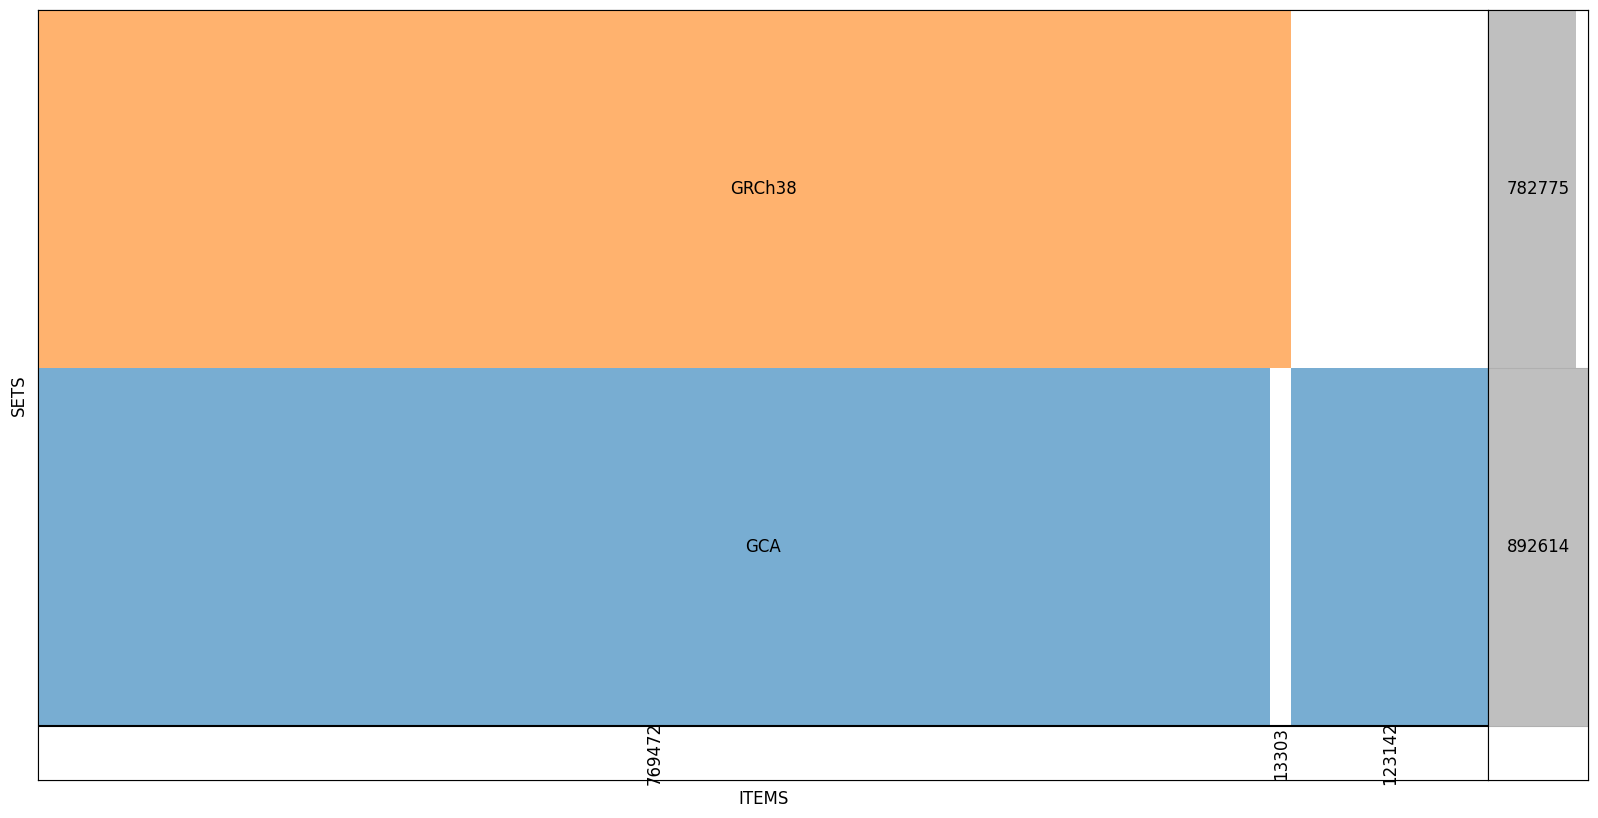

In [12]:
# Plot the overlap between the samples and the GRCH38 reference
labels = list(peptides.keys())
sets = [set(peptides[x]) for x in peptides.keys()]

plt.figure(figsize=(20, 10))
supervenn(sets, labels, min_width_for_annotation=10000, rotate_col_annotations=True, 
          side_plots='right', chunks_ordering='occurrence', alternating_background= False)

plt.grid(False)
plt.savefig('coding_baroverlap.pdf')


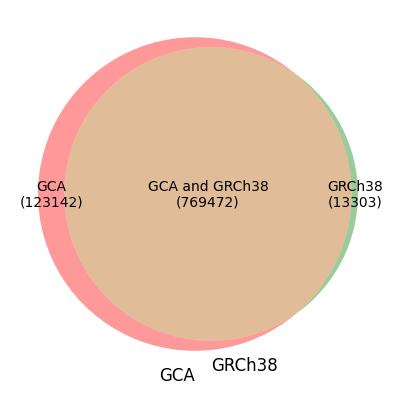

In [13]:
labels = list(peptides.keys())
sets = [set(peptides[x]) for x in peptides.keys()]
venn = venn2(sets, set_labels=labels)

venn.get_label_by_id('100').set_text(f'GCA\n({len(peptides["GCA"] - peptides["GRCh38"])})')
venn.get_label_by_id('010').set_text(f'GRCh38\n({len(peptides["GRCh38"] - peptides["GCA"])})')
venn.get_label_by_id('110').set_text(f'GCA and GRCh38\n({len(peptides["GCA"].intersection(peptides["GRCh38"]))})')

plt.savefig('gen_coding_peptide.svg', format='svg')
plt.show()

In [14]:
peptides = get_tryptic_peps(tryptic_pep_dir, gen_prot_files, min_pep_len)
print('Number of tryptic peptides per type:\n', '\n'.join([k+' = '+str(len(items)) for k,items in peptides.items()]))

Number of tryptic peptides per type:
 GCA = 9791203
GRCh38 = 8084394


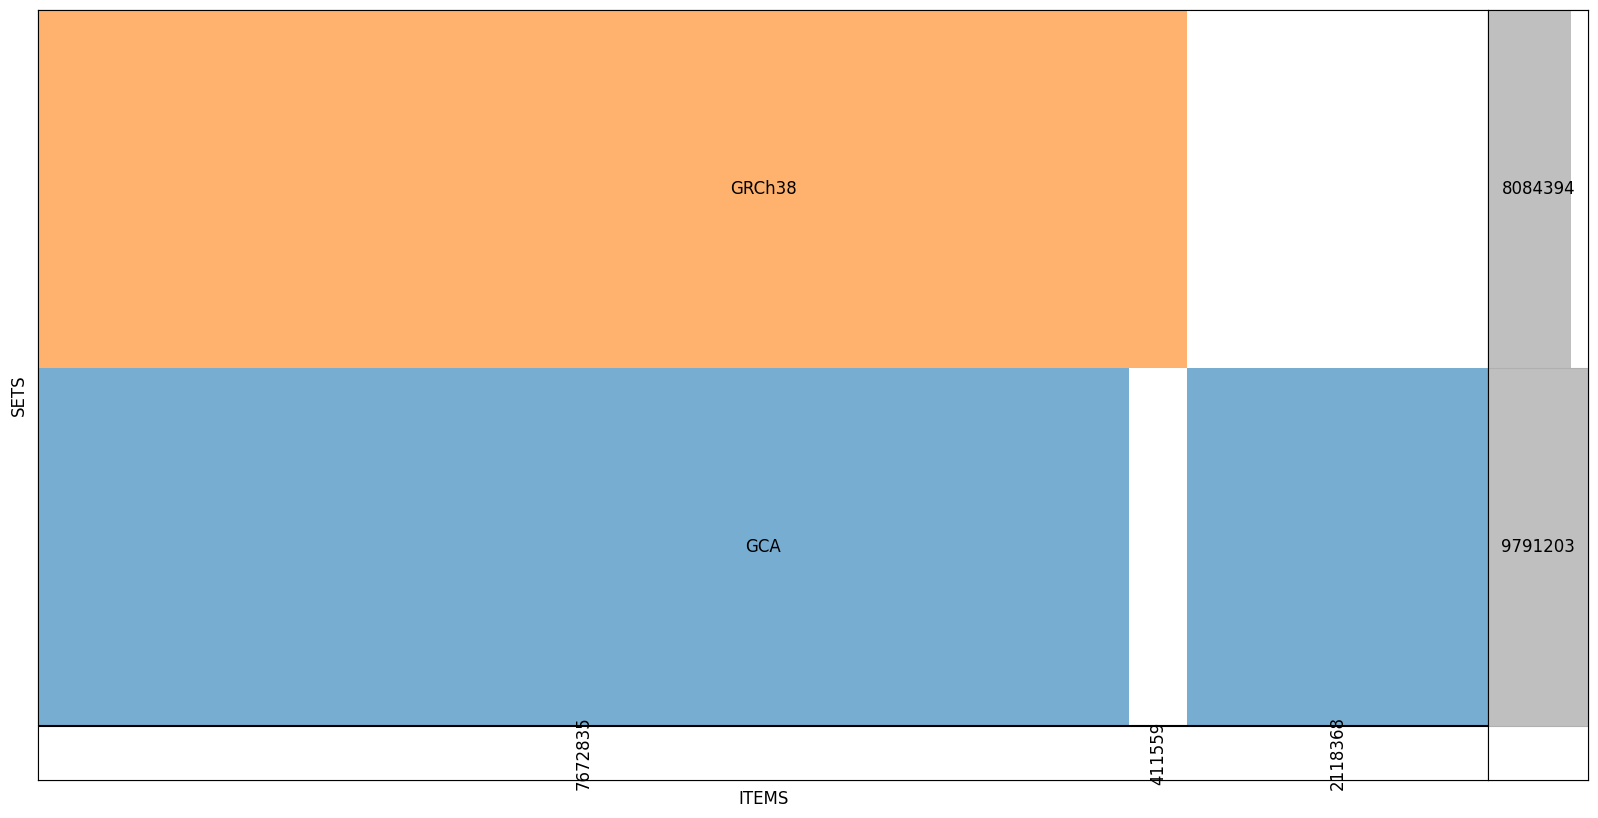

In [15]:
# Plot the overlap between the samples and the GRCH38 reference
labels = list(peptides.keys())
sets = [set(peptides[x]) for x in peptides.keys()]

plt.figure(figsize=(20, 10))
supervenn(sets, labels, min_width_for_annotation=10000, rotate_col_annotations=True, 
          side_plots='right', chunks_ordering='occurrence', alternating_background= False)

plt.grid(False)
plt.savefig('noncan_baroverlap.pdf')


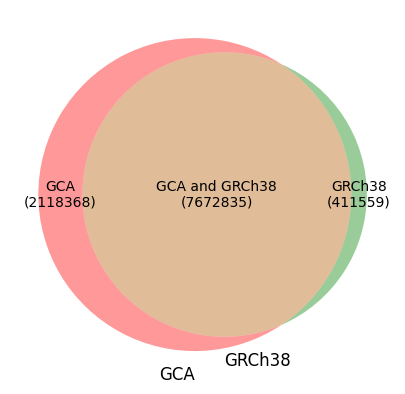

In [16]:
labels = list(peptides.keys())
sets = [set(peptides[x]) for x in peptides.keys()]
venn = venn2(sets, set_labels=labels)

venn.get_label_by_id('100').set_text(f'GCA\n({len(peptides["GCA"] - peptides["GRCh38"])})')
venn.get_label_by_id('010').set_text(f'GRCh38\n({len(peptides["GRCh38"] - peptides["GCA"])})')
venn.get_label_by_id('110').set_text(f'GCA and GRCh38\n({len(peptides["GCA"].intersection(peptides["GRCh38"]))})')

plt.savefig('gen_peptide.svg', format='svg')
plt.show()

## uniprot

In [17]:
def get_protein_set(protein_fasta):
    proteins = set()
    for record in SeqIO.parse(protein_fasta, 'fasta'):
        proteins.add(str(record.seq))
    return proteins

GCA_proteins = get_protein_set(prot_dir+"/GCA_proteins_19Jul23.fa")
GRCh38_proteins = get_protein_set(prot_dir+"/GRCh38_proteins_19Jul23.fa")
proteins = {"GCA":GCA_proteins,"GRCh38":GRCh38_proteins}

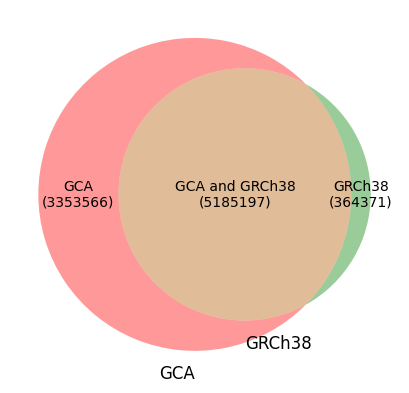

In [18]:
labels = list(proteins.keys())
sets = [set(proteins[x]) for x in proteins.keys()]
venn = venn2(sets, set_labels=labels)

venn.get_label_by_id('100').set_text(f'GCA\n({len(proteins["GCA"] - proteins["GRCh38"])})')
venn.get_label_by_id('010').set_text(f'GRCh38\n({len(proteins["GRCh38"] - proteins["GCA"])})')
venn.get_label_by_id('110').set_text(f'GCA and GRCh38\n({len(proteins["GCA"].intersection(proteins["GRCh38"]))})')

plt.savefig('protein.svg', format='svg')
plt.show()

## Explore contents of the database

In [14]:
biotypes_counts = {}
def get_biotype_counts(db_file):
    for n, record in enumerate(SeqIO.parse(db_file, 'fasta')):
        desc = str(record.description).split(' ')
        proj = desc[0]
        biotype = desc[-1]
        seqs = str(record.seq)
        try:
            biotypes_counts[biotype]+=1
        except KeyError:
            biotypes_counts[biotype] = 1
    return biotypes_counts


def plot_counts(counts, min_other, fig_pdf):
    items = []
    values = []
    other = 0
    for k in can_biotypes_dict.keys():
        if can_biotypes_dict[k]>min_other:
            items.append(k.replace('nonsense_mediated_decay','nmd').replace('protein_coding_CDS_not_defined', 'pc-Ncds'))
            values.append(can_biotypes_dict[k])
        else:
            other+=can_biotypes_dict[k]
    items.append('other')
    values.append(other)
    plt.figure(figsize=(20, 10))
    sns.set_style("ticks")
    barplot = sns.barplot(x=items, y=values)
    sns.despine(right=True,top=True,left=False)
    plt.xticks(rotation=90)
    plt.savefig(fig_pdf)
    
    return barplot

<Axes: >

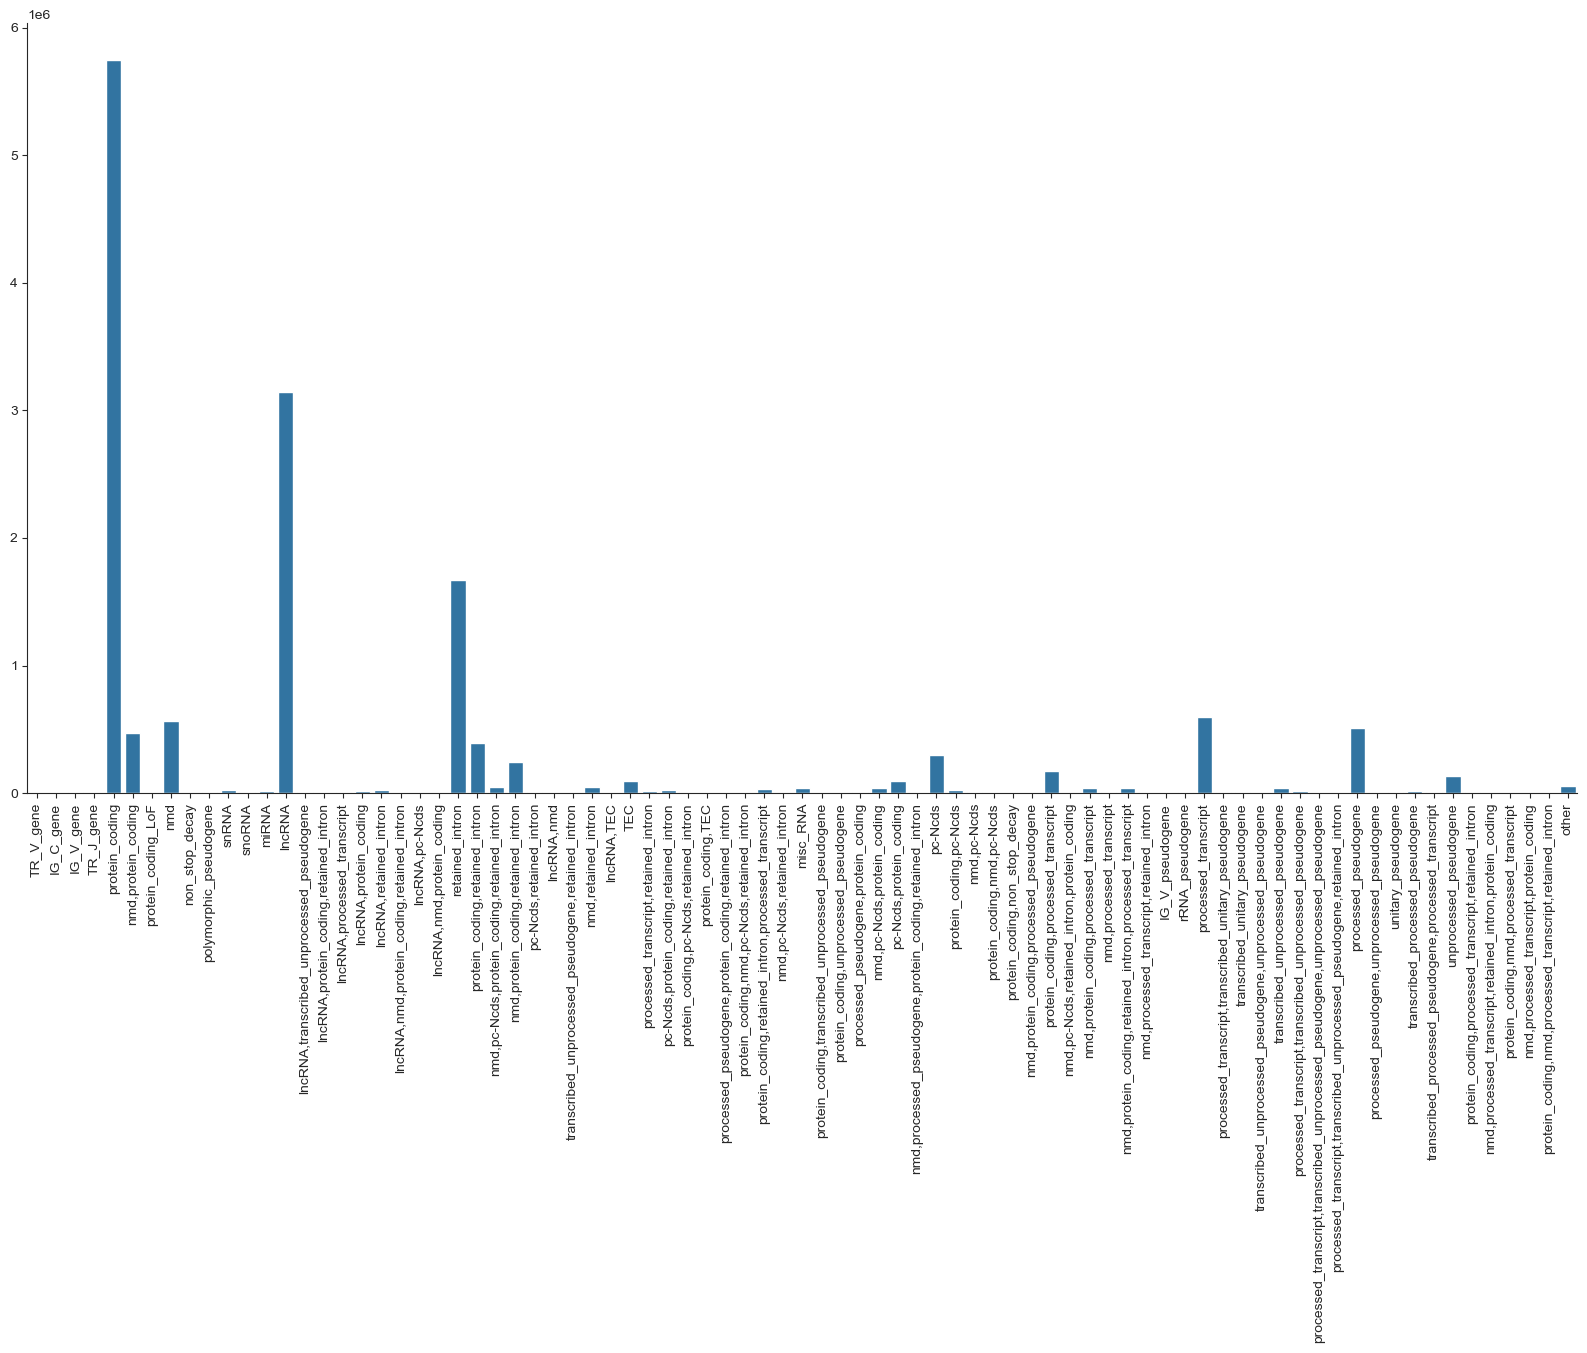

In [17]:
can_db_file = '../GRCh38r110_GCA97s_coding_proteins_19Jul23.fa'
can_biotypes_dict = get_biotype_counts(can_db_file)
plot_counts(can_biotypes_dict, 1000, 'can_biotype_counts.pdf')

<Axes: >

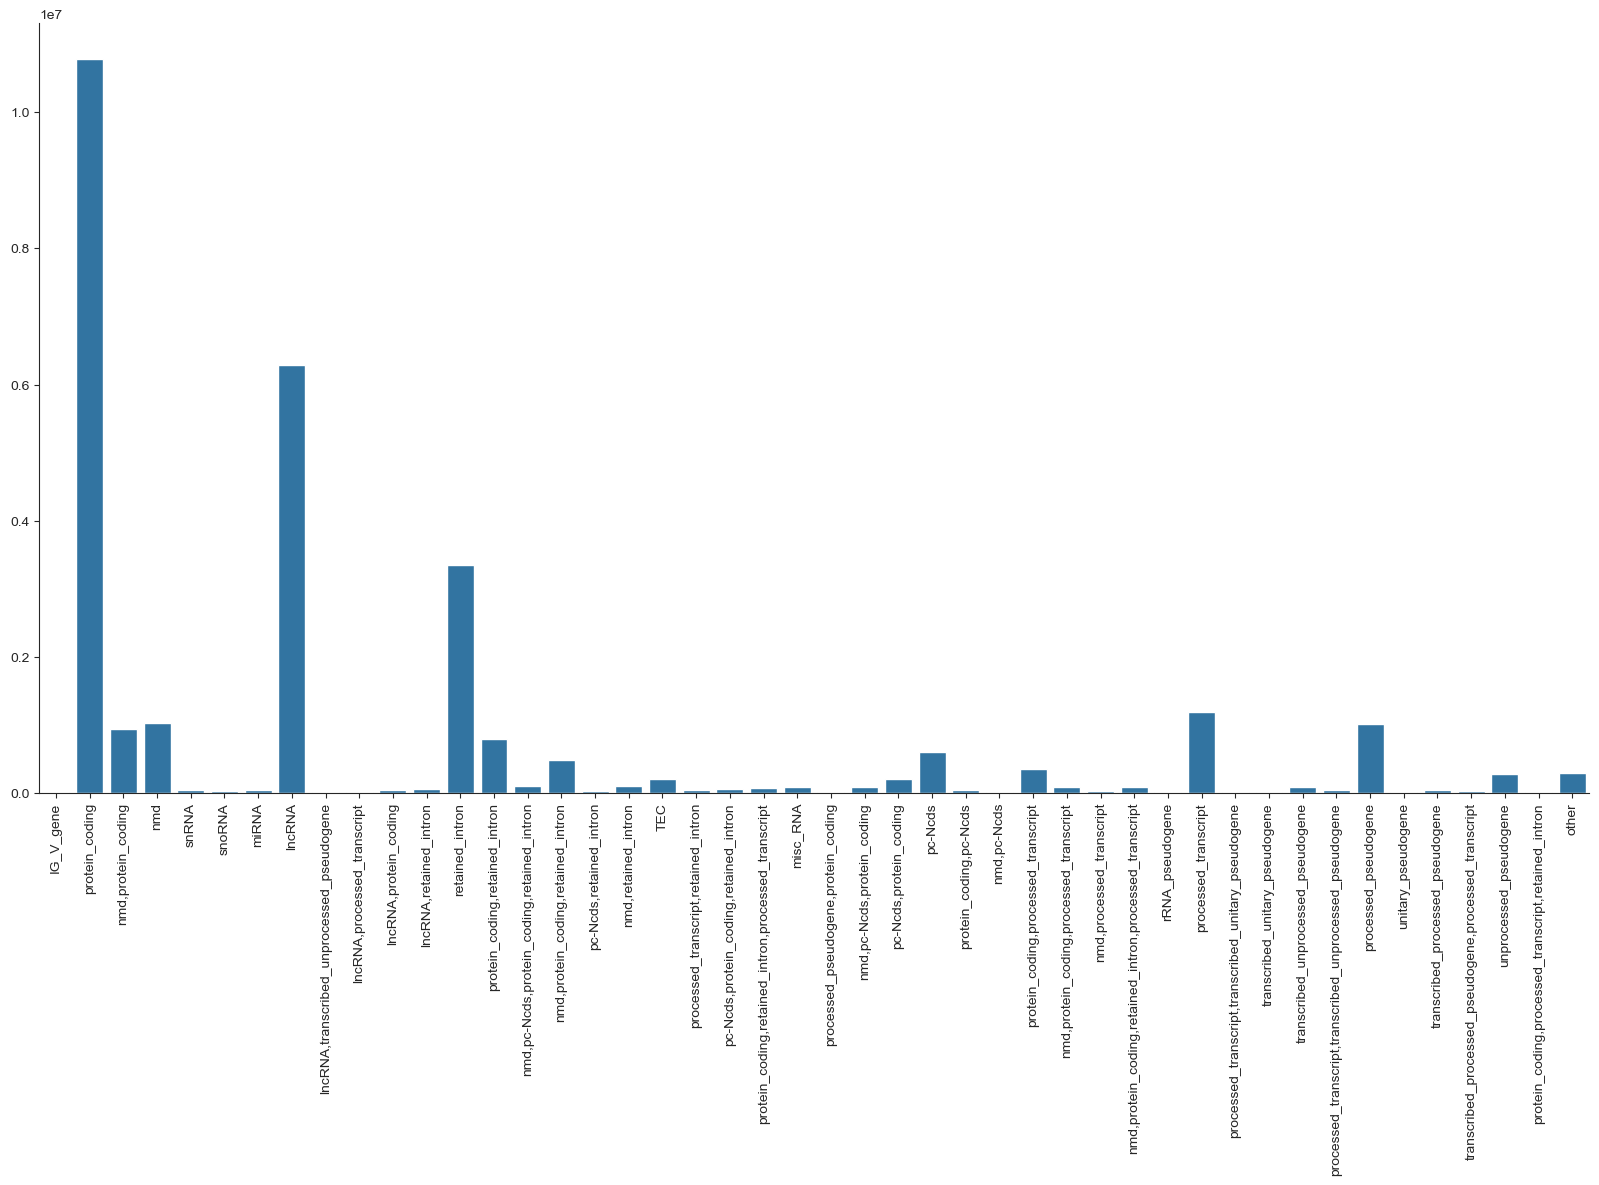

In [18]:
noncan_db_file = '../GRCh38r110_GCA97s_noncanonical_proteins_19Jul23.fa'
noncan_biotypes_dict = get_biotype_counts(noncan_db_file)
plot_counts(noncan_biotypes_dict, 10000, 'noncan_biotype_counts.pdf')